# End-to-End Training

In [1]:
import os
import cv2
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import pickle
import random

from ssd.ssd import SSD, Detector, UpSample, DownSample
from ssd.ssd_loss import MultiboxLoss
from ssd.ssd_bbox import BBoxUtility

%matplotlib inline
plt.rcParams['figure.figsize'] = (8, 8)
plt.rcParams['image.interpolation'] = 'nearest'

np.set_printoptions(suppress=True)

# config = tf.ConfigProto()
# config.gpu_options.per_process_gpu_memory_fraction = 0.9
# set_session(tf.Session(config=config))

# Notebook auto reloads code. (Ref: http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython)
% load_ext autoreload
% autoreload 2

### load data

In [2]:
# some constants
NUM_CLASSES = 4 # remember the background 
input_shape = (384, 384, 3)

In [3]:
"""
tf.reset_default_graph()
## priorbox defined by ourselves
prior_tensor = tf.ones((1, 300, 300, 3))
ssd_net = SSD(input_shape, NUM_CLASSES)
_, priors = ssd_net(prior_tensor, PRIORS = True)
print(priors.shape)
"""

'\ntf.reset_default_graph()\n## priorbox defined by ourselves\nprior_tensor = tf.ones((1, 300, 300, 3))\nssd_net = SSD(input_shape, NUM_CLASSES)\n_, priors = ssd_net(prior_tensor, PRIORS = True)\nprint(priors.shape)\n'

In [20]:
# DEBUG by tensorboard

g = tf.Graph()
with g.as_default():
    #a = tf.placeholder(tf.float32, name="a")
    #b = tf.placeholder(tf.float32, name="b")
    #c = a + b
    ## priorbox defined by ourselves
    input_tensor = tf.ones((1, 384, 384, 3))
    ssd_net = SSD()
    feats = ssd_net(input_tensor)
    detect_net = Detector(input_shape, NUM_CLASSES)
    priors = detect_net(feats, PRIORS=True)
    print(priors.shape)
    
tf.summary.FileWriter("logs", g).close()

(?, 10368, 8)


In [22]:
with g.as_default():
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        priors_np = sess.run(priors)

# save priors tensor
with open('./data/priors384.pkl', 'wb') as handle:
    pickle.dump(np.squeeze(priors_np), handle)

In [4]:
# load priors tensor
with open('./data/priors384.pkl', 'rb') as handle:
    priors_np = pickle.load(handle)
    print(priors_np.shape)

(10368, 8)


### bbox

In [5]:
#sess = tf.InteractiveSession()
#sess.run(tf.global_variables_initializer())
#priors_np = np.squeeze(sess.run(priors))
bbox_util = BBoxUtility(NUM_CLASSES, priors_np)

In [6]:
print([None,] + list(priors_np.shape))

[None, 10368, 8]


#### load data

In [7]:
seq_length = 4
batch_size = 4

In [8]:
# load annotations
with open('./data/0254.pkl', 'rb') as handle:
    annotation0254 = pickle.load(handle)

In [9]:
## bounding box ground truth
gt = dict(pickle.load(open('./data/0254.pkl', 'rb')))
#keys = list(gt.keys())
keys = sorted(gt.keys())
num_train = int(round(0.8 * len(keys)))
train_keys = keys[:num_train]
val_keys = keys[num_train:]
num_val = len(val_keys)
print(num_train)
print(num_val)

58
14


In [10]:
from ssd.preprocess import *
path_prefix = './data/0254img/'

# batch_size = 4
gen = SeqGenerator(gt, bbox_util, batch_size, path_prefix,
                train_keys, val_keys, input_shape, seq_length)

Using TensorFlow backend.


In [11]:
train_generator = gen.generate(True)
val_generator = gen.generate(False)

## Conv2DLSTM

#### final end-to-end model

In [12]:
#tf.reset_default_graph()
g = tf.Graph()
with g.as_default():
    seq_input_ph = tf.placeholder(tf.float32, [None, seq_length] + list(input_shape), name="input_image")
    gt_ph = tf.placeholder(tf.float32, [None, priors_np.shape[0], 16], name="ground_truth")

    with tf.variable_scope("ssd_net"):
        ssd_net = SSD()
        ssd_input = tf.reshape(seq_input_ph, [-1,]+list(input_shape), name="reshape_seq_input")
        feats = ssd_net(ssd_input)
        #seq_feats = tf.reshape(ssd_input, [-1, seq_length]+list(input_shape), name="reshape_seq")

    #with tf.variable_scope("up_net"):
    #    upsample_net = UpSample()
    #    feats_up, up_factors = upsample_net(feats)
    #    seq_feats_up = tf.reshape(ssd_input, [-1, seq_length]+feats_up.get_shape().as_list()[-3:], name="reshape_seq_up")

    with tf.variable_scope("core_conv_lstm"):
        pred_feats = []
        for i, feat in enumerate(feats):
            seq_feat = tf.reshape(feat, [-1, seq_length]+feat.get_shape().as_list()[-3:], name="reshape_seq_{}".format(i))
            cell = tf.contrib.rnn.Conv2DLSTMCell(input_shape=feat.get_shape().as_list()[-3:], 
                                                 output_channels=feat.get_shape().as_list()[-1], kernel_shape=[5,5], name="convrnncell_{}".format(i))
            init_state = cell.zero_state(batch_size, tf.float32)
            outputs, final_state = tf.nn.dynamic_rnn(cell, seq_feat, dtype=tf.float32, scope="rnn_{}".format(i))
            pred_feats.append(final_state[-1])
            
        # last feature vector
        #seq_feat = tf.reshape(feats[-1], [-1, seq_length]+feats[-1].get_shape().as_list()[-1:], name="last_reshape_seq")
        #cell = tf.contrib.rnn.LSTMCell(128)
        #init_state = cell.zero_state(batch_size, tf.float32)
        #outputs, final_state = tf.nn.dynamic_rnn(cell, seq_feat, dtype=tf.float32, scope="last_dense_rnn")
        #pred_feats.append(final_state[-1])
        
    #with tf.variable_scope("down_pooling"):
    #    down_net = DownSample()
    #    feats_down = down_net(final_state[-1], up_factors) # final_state: (c, h)
        
    with tf.variable_scope("final_prediction"):
        detector = Detector(input_shape, NUM_CLASSES)
        #predictions = detector(feats, PRIORS=False)
        final_predictions = detector(pred_feats, PRIORS=False)
        
    with tf.variable_scope("loss"):
        loss = MultiboxLoss(NUM_CLASSES, neg_pos_ratio=2.0).compute_loss(gt_ph, final_predictions)
    
    with tf.variable_scope("train"):
        global_step = tf.Variable(0, trainable=False)
        lr = tf.train.exponential_decay(3e-4, global_step, num_train//batch_size, 0.9, staircase=True, name="lr")
        train_op = tf.train.AdamOptimizer(learning_rate=lr).minimize(loss, global_step=global_step)

/home/ecbm4040/miniconda2/envs/dlenv/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [13]:
tf.summary.FileWriter("logs", g).close()

#### train

In [12]:
tf.reset_default_graph()
#g = tf.Graph()
#with g.as_default():
seq_input_ph = tf.placeholder(tf.float32, [None, seq_length] + list(input_shape), name="input_image")
gt_ph = tf.placeholder(tf.float32, [None, priors_np.shape[0], 16], name="ground_truth")

with tf.variable_scope("ssd_net"):
    ssd_net = SSD()
    ssd_input = tf.reshape(seq_input_ph, [-1,]+list(input_shape), name="reshape_seq_input")
    feats = ssd_net(ssd_input)
    #seq_feats = tf.reshape(ssd_input, [-1, seq_length]+list(input_shape), name="reshape_seq")

#with tf.variable_scope("up_net"):
#    upsample_net = UpSample()
#    feats_up, up_factors = upsample_net(feats)
#    seq_feats_up = tf.reshape(ssd_input, [-1, seq_length]+feats_up.get_shape().as_list()[-3:], name="reshape_seq_up")

with tf.variable_scope("core_conv_lstm"):
    pred_feats = []
    for i, feat in enumerate(feats):
        seq_feat = tf.reshape(feat, [-1, seq_length]+feat.get_shape().as_list()[-3:], name="reshape_seq_{}".format(i))
        cell = tf.contrib.rnn.Conv2DLSTMCell(input_shape=feat.get_shape().as_list()[-3:], 
                                             output_channels=feat.get_shape().as_list()[-1], kernel_shape=[5,5], name="convrnncell_{}".format(i))
        init_state = cell.zero_state(batch_size, tf.float32)
        outputs, final_state = tf.nn.dynamic_rnn(cell, seq_feat, dtype=tf.float32, scope="rnn_{}".format(i))
        pred_feats.append(final_state[-1])

    # last feature vector
    #seq_feat = tf.reshape(feats[-1], [-1, seq_length]+feats[-1].get_shape().as_list()[-1:], name="last_reshape_seq")
    #cell = tf.contrib.rnn.LSTMCell(128)
    #init_state = cell.zero_state(batch_size, tf.float32)
    #outputs, final_state = tf.nn.dynamic_rnn(cell, seq_feat, dtype=tf.float32, scope="last_dense_rnn")
    #pred_feats.append(final_state[-1])

#with tf.variable_scope("down_pooling"):
#    down_net = DownSample()
#    feats_down = down_net(final_state[-1], up_factors) # final_state: (c, h)

with tf.variable_scope("final_prediction"):
    detector = Detector(input_shape, NUM_CLASSES)
    #predictions = detector(feats, PRIORS=False)
    final_predictions = detector(pred_feats, PRIORS=False)

with tf.variable_scope("loss"):
    loss = MultiboxLoss(NUM_CLASSES, neg_pos_ratio=2.0).compute_loss(gt_ph, final_predictions)

with tf.variable_scope("train"):
    global_step = tf.Variable(0, trainable=False)
    lr = tf.train.exponential_decay(3e-4, global_step, num_train//batch_size, 0.9, staircase=True, name="lr")
    train_op = tf.train.AdamOptimizer(learning_rate=lr).minimize(loss, global_step=global_step)

/home/ecbm4040/miniconda2/envs/dlenv/lib/python3.5/site-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [13]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()

In [25]:
train_loss_hist = []
nb_epoch = 20
for e in range(nb_epoch):
    # training phase
    cnt = 0
    for sample in train_generator:
        _, train_input, train_target, _ = sample
        train_loss, _ = sess.run([loss, train_op], feed_dict={seq_input_ph: train_input, gt_ph: train_target})
        train_loss_hist.append(np.mean(train_loss))
        cnt += 1
        print("training {}/{}, minibatch loss: {}".format(cnt*batch_size, num_train, train_loss))
        if cnt > (num_train//batch_size):
            cnt = 0
            break
        
    # validation phase
    val_loss = 0.0
    for sample in val_generator:
        _, val_input, val_target, _ = sample
        val_loss += np.sum(sess.run(loss, feed_dict={seq_input_ph: val_input, gt_ph: val_target}))
        cnt += 1
        if cnt > (num_val//batch_size):
            cnt = 0
            break
    
    # print progress
    verbose_loss = np.mean(train_loss_hist[-(num_train//batch_size+1):])
    verbose_val_loss = val_loss/((num_val//batch_size+1)*batch_size)
    print("epoch {}/{}, train loss: {}, val loss: {}".format(e+1, nb_epoch, verbose_loss, verbose_val_loss))

training 4/58, minibatch loss: [ 1.0758419   1.70854425  1.10511971  1.45909619]
training 8/58, minibatch loss: [ 1.53961921  1.07724428  1.46413291  1.50091183]
training 12/58, minibatch loss: [ 1.6390028   1.33940744  1.25190878  1.98456311]
training 16/58, minibatch loss: [ 1.48577166  1.31297135  1.21004748  1.58185005]
training 20/58, minibatch loss: [ 1.70921707  1.14655781  1.35727096  1.97767401]
training 24/58, minibatch loss: [ 1.52836275  1.13719058  1.41135335  1.94606423]
training 28/58, minibatch loss: [ 1.485165    1.86345911  0.8954944   1.38935208]
training 32/58, minibatch loss: [ 1.85450554  1.19880295  0.8969444   1.44832301]
training 36/58, minibatch loss: [ 1.44024348  1.18511498  1.5438478   0.89962882]
training 40/58, minibatch loss: [ 1.24870372  1.4406209   1.19573653  1.47912371]
training 44/58, minibatch loss: [ 1.21293402  1.84475017  1.17713845  1.3930943 ]
training 48/58, minibatch loss: [ 1.07748294  1.38193917  1.35201931  1.50093496]
training 52/58, mi

training 24/58, minibatch loss: [ 1.01476276  1.44442749  1.22339702  1.4186964 ]
training 28/58, minibatch loss: [ 0.89615488  1.61409545  1.33048749  1.24665308]
training 32/58, minibatch loss: [ 2.20196247  1.08199513  1.20316672  1.13858008]
training 36/58, minibatch loss: [ 1.25637698  1.45479727  1.41898727  1.241575  ]
training 40/58, minibatch loss: [ 1.39785862  1.05178523  1.07048583  1.22312903]
training 44/58, minibatch loss: [ 1.45966887  1.39723825  1.39541674  1.05848145]
training 48/58, minibatch loss: [ 1.56698942  1.51074505  2.15769672  1.67349291]
training 52/58, minibatch loss: [ 1.0782156   1.35701489  1.07320452  0.95402718]
training 56/58, minibatch loss: [ 2.2388978   1.1992147   2.09676504  1.06852889]
training 60/58, minibatch loss: [ 1.24762821  1.93408179  1.36249113  1.372967  ]
epoch 7/20, train loss: 1.35685396194458, val loss: 1.5613436102867126
training 4/58, minibatch loss: [ 1.858114    1.22716856  1.17314208  1.52564192]
training 8/58, minibatch los

training 44/58, minibatch loss: [ 1.23462605  0.95102608  1.31982625  1.31606793]
training 48/58, minibatch loss: [ 1.18438745  1.29180765  1.18505955  1.40161872]
training 52/58, minibatch loss: [ 1.17320776  1.42516971  1.64541554  1.78087926]
training 56/58, minibatch loss: [ 1.00613701  1.58580756  1.01522231  1.4275502 ]
training 60/58, minibatch loss: [ 1.00998259  1.01365137  0.98754025  1.22736096]
epoch 13/20, train loss: 1.280571699142456, val loss: 1.4900869727134705
training 4/58, minibatch loss: [ 1.31663895  1.29342246  1.03608155  1.58575082]
training 8/58, minibatch loss: [ 1.11167252  1.29578125  0.9591713   0.87931877]
training 12/58, minibatch loss: [ 1.3487165   1.19824839  1.01021934  1.28114843]
training 16/58, minibatch loss: [ 1.37794876  1.36182511  1.14643359  1.00651693]
training 20/58, minibatch loss: [ 1.60135055  1.40253782  1.34039879  1.23992634]
training 24/58, minibatch loss: [ 1.38793063  1.11859965  1.02788353  0.9714635 ]
training 28/58, minibatch l

epoch 19/20, train loss: 1.2701019048690796, val loss: 1.468676507472992
training 4/58, minibatch loss: [ 0.97724128  0.7627784   1.48475325  1.40779889]
training 8/58, minibatch loss: [ 1.37552309  0.97586328  1.48372316  0.99384755]
training 12/58, minibatch loss: [ 0.89292127  1.29117751  1.36442327  1.30366182]
training 16/58, minibatch loss: [ 0.98731482  1.33078241  1.17625999  1.27346182]
training 20/58, minibatch loss: [ 1.20418572  0.98685968  1.08161354  0.95730722]
training 24/58, minibatch loss: [ 1.88394809  1.5740416   1.44016171  1.26790082]
training 28/58, minibatch loss: [ 1.35066271  1.1106391   0.98679566  1.16748405]
training 32/58, minibatch loss: [ 1.23427379  1.167678    0.94882548  0.93690479]
training 36/58, minibatch loss: [ 1.06725955  1.3379879   1.3614825   1.28832328]
training 40/58, minibatch loss: [ 1.46068335  1.10272253  0.93924689  0.8038252 ]
training 44/58, minibatch loss: [ 1.33553648  1.36289716  1.23593974  1.09130085]
training 48/58, minibatch l

### evaluate

In [29]:
for sample in train_generator:
    seq_keys, seq_eval_input, _, seq_eval_target_img = sample
    break

In [30]:
eval_pred = sess.run(final_predictions, feed_dict={seq_input_ph: seq_eval_input})
results = bbox_util.detection_out(eval_pred)

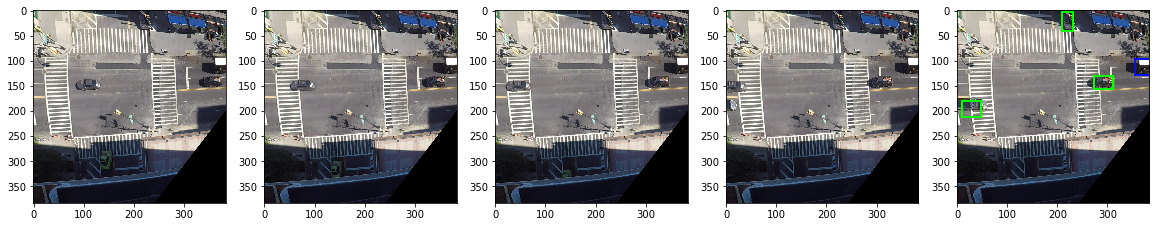

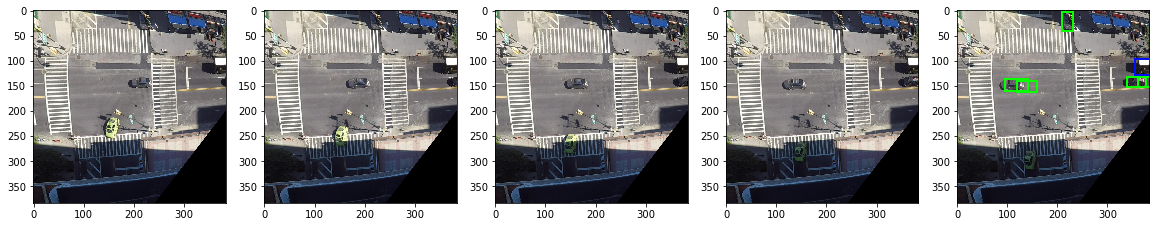

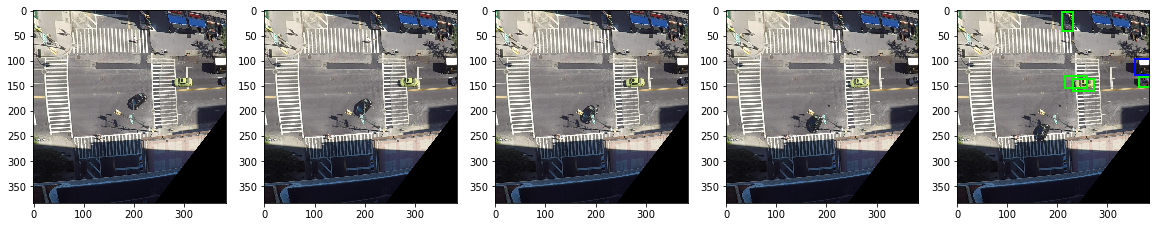

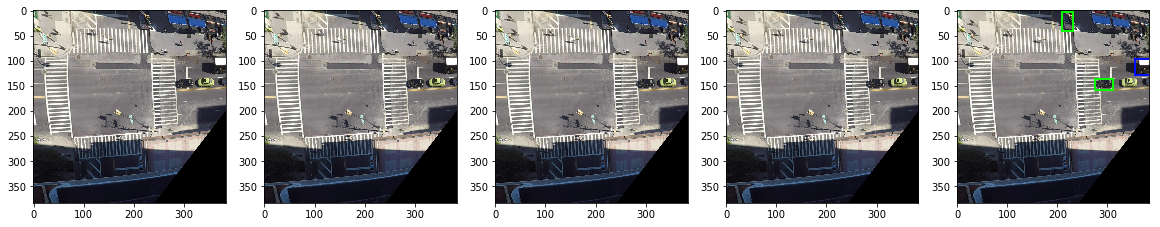

In [32]:
for i, result in enumerate(results[:]):
    # Parse the outputs.
    det_label = results[i][:, 0]
    det_conf = results[i][:, 1]
    det_xmin = results[i][:, 2]
    det_ymin = results[i][:, 3]
    det_xmax = results[i][:, 4]
    det_ymax = results[i][:, 5]

    # Get detections with confidence higher than 0.6.
    top_indices = [i for i, conf in enumerate(det_conf) if conf >= 0.3]
    top_conf = det_conf[top_indices]
    top_label_indices = det_label[top_indices].tolist()
    top_xmin = det_xmin[top_indices]
    top_ymin = det_ymin[top_indices]
    top_xmax = det_xmax[top_indices]
    top_ymax = det_ymax[top_indices]

    colors = plt.cm.hsv(np.linspace(0, 1, 4)).tolist()
    
    f, axarr = plt.subplots(1, seq_length+1, figsize=(20,100))
    #plt.imshow(img / 255.)
    #currentAxis = plt.gca()
    for j in range(seq_length):
        img = seq_eval_input[i,j,:,:,:]
        axarr[j].imshow(((img+1.)*127.5).astype("uint8")[:,:,::-1])
    img = seq_eval_target_img[i,:,:,:]
    axarr[-1].imshow(img.astype("uint8")[:,:,::-1])

    for i in range(top_conf.shape[0]):
        xmin = int(round(top_xmin[i] * img.shape[1]))
        ymin = int(round(top_ymin[i] * img.shape[0]))
        xmax = int(round(top_xmax[i] * img.shape[1]))
        ymax = int(round(top_ymax[i] * img.shape[0]))
        score = top_conf[i]
        label = int(top_label_indices[i])
#         label_name = voc_classes[label - 1]
        #display_txt = '{:0.2f}, {}'.format(score, label)
        coords = (xmin, ymin), xmax-xmin+1, ymax-ymin+1
        color = colors[label]
        axarr[-1].add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        #currentAxis.text(xmin, ymin, display_txt, bbox={'facecolor':color, 'alpha':0.5})
    
    plt.show()